# Spatial profiles along slit from FORS1 spectra

I would like to achieve the following:

1. [X] Identify W 3 and the bow shock in the spectra
2. [ ] Trace the full western extent of the bow shock in [Ar IV]
    - the MUSE field extends only 22 arcsec from the star
    - the FORS1 spectrum shows a roughly linear ramp that extends about 34 arcsec (see image below)
3. [ ] Calculate the [O III] 4363/5007 temperature profile of the bow shock
    - See if there is any evidence for temperatures as high as the [Ar IV] temperature
4. [ ] Measure the [Ne III] 3869 profile.  Ne$^+$ has the same ionization potential as Ar$^{+2}$ (40 eV), but [Ne III] seems to be much more broadly distributed than [Ar IV]



![FORS1 profile of Ar IV](assets/ngc346-screenshot-fors1-ariv-profile.png)



In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import regions
from astropy.io import fits
from astropy.wcs import WCS
import sys

sys.path.append("../lib")
import extract

sns.set_context("talk")
sns.set_color_codes()

Load line and continuum images for the two blue spectral ranges.  We may use the continuum for masking out regions that have excessive stellar contamination.

In [2]:
hdu1 = fits.open("../data/ngc346-fors1-A-3500-4600-contsub.fits")[0]
hdu2 = fits.open("../data/ngc346-fors1-A-4400-6000-contsub.fits")[0]
hdu1c = fits.open("../data/ngc346-fors1-A-3500-4600-cont.fits")[0]
hdu2c = fits.open("../data/ngc346-fors1-A-4400-6000-cont.fits")[0]

In [3]:
hdu1B = fits.open("../data/ngc346-fors1-B-3562-4600-contsub.fits")[0]
hdu2B = fits.open("../data/ngc346-fors1-B-4400-6000-contsub.fits")[0]
hdu1cB = fits.open("../data/ngc346-fors1-B-3562-4600-cont.fits")[0]
hdu2cB = fits.open("../data/ngc346-fors1-B-4400-6000-cont.fits")[0]

Set up the world coords for the two ranges

In [4]:
wcs1 = WCS(hdu1)
wcs2 = WCS(hdu2)
wcs1B = WCS(hdu1B)
wcs2B = WCS(hdu2B)
for w in wcs1, wcs2, wcs1B, wcs2B:
    w.wcs.cdelt[1] *= -1.0

Set up the lines that we want with wavelength limits:

In [5]:
pv1A = extract.PositionVelocityImage(hdu1.data, wcs1)
pv2A = extract.PositionVelocityImage(hdu2.data, wcs2)
pvc1A = extract.PositionVelocityImage(hdu1c.data, wcs1)
pvc2A = extract.PositionVelocityImage(hdu2c.data, wcs2)
pv1B = extract.PositionVelocityImage(hdu1B.data, wcs1B)
pv2B = extract.PositionVelocityImage(hdu2B.data, wcs2B)
pvc1B = extract.PositionVelocityImage(hdu1cB.data, wcs1B)
pvc2B = extract.PositionVelocityImage(hdu2cB.data, wcs2B)

In [171]:
restwav = {
    "He II 4686": 4685.68,
    "[Ar IV] 4740": 4740.17,
    "[O III] 5007": 5006.84,
    "[O III] 4363": 4363.209,
    "[Ne III] 3869": 3869.07,
    "H I 4861": 4861.32,
    "H I 4340": 4340.463,
    "H I 4102": 4101.735,
    "He I 5876": 5875.62,
    "[Cl III] 5518": 5517.71,
    "[Cl III] 5538": 5537.88,
    "[N II] 5755": 5755.08,
    "[Fe III] 4658": 4658.10,
    "[Fe III] 4987": 4987.20,
    "[Fe III] 5270": 5270.4,
    "O II 4650": 4650.00,
    "[O II] 3729": 3728.815,
    "[O II] 3726": 3726.032, 
    "Wing 4975": 4975.0,
}

In [172]:
emlines = {k: extract.EmissionLine(k, v) for k, v in restwav.items()}

In [173]:
emlines

{'He II 4686': EmissionLine(name='He II 4686', wav0=4685.68, vlim=(-50.0, 500.0)),
 '[Ar IV] 4740': EmissionLine(name='[Ar IV] 4740', wav0=4740.17, vlim=(-50.0, 500.0)),
 '[O III] 5007': EmissionLine(name='[O III] 5007', wav0=5006.84, vlim=(-50.0, 500.0)),
 '[O III] 4363': EmissionLine(name='[O III] 4363', wav0=4363.209, vlim=(-50.0, 500.0)),
 '[Ne III] 3869': EmissionLine(name='[Ne III] 3869', wav0=3869.07, vlim=(-50.0, 500.0)),
 'H I 4861': EmissionLine(name='H I 4861', wav0=4861.32, vlim=(-50.0, 500.0)),
 'H I 4340': EmissionLine(name='H I 4340', wav0=4340.463, vlim=(-50.0, 500.0)),
 'H I 4102': EmissionLine(name='H I 4102', wav0=4101.735, vlim=(-50.0, 500.0)),
 'He I 5876': EmissionLine(name='He I 5876', wav0=5875.62, vlim=(-50.0, 500.0)),
 '[Cl III] 5518': EmissionLine(name='[Cl III] 5518', wav0=5517.71, vlim=(-50.0, 500.0)),
 '[Cl III] 5538': EmissionLine(name='[Cl III] 5538', wav0=5537.88, vlim=(-50.0, 500.0)),
 '[N II] 5755': EmissionLine(name='[N II] 5755', wav0=5755.08, vlim=

In [174]:
for em in emlines.values():
    if em.wav0 > 4400:
        em.pvA = pv2A
        em.pvB = pv2B
        em.pvcA = pvc2A
        em.pvcB = pvc2B
    else:
        em.pvA = pv1A
        em.pvB = pv1B
        em.pvcA = pvc1A
        em.pvcB = pvc1B

In [175]:
for em in emlines.values():
    em.A = em.pvA.slit_profile(em)
    em.ewA = em.pvA.slit_ew_profile(em, em.pvcA)
    em.cA = em.pvcA.slit_profile(em)
    em.B = em.pvB.slit_profile(em)
    em.ewB = em.pvB.slit_ew_profile(em, em.pvcB)
    em.cB = em.pvcB.slit_profile(em)    

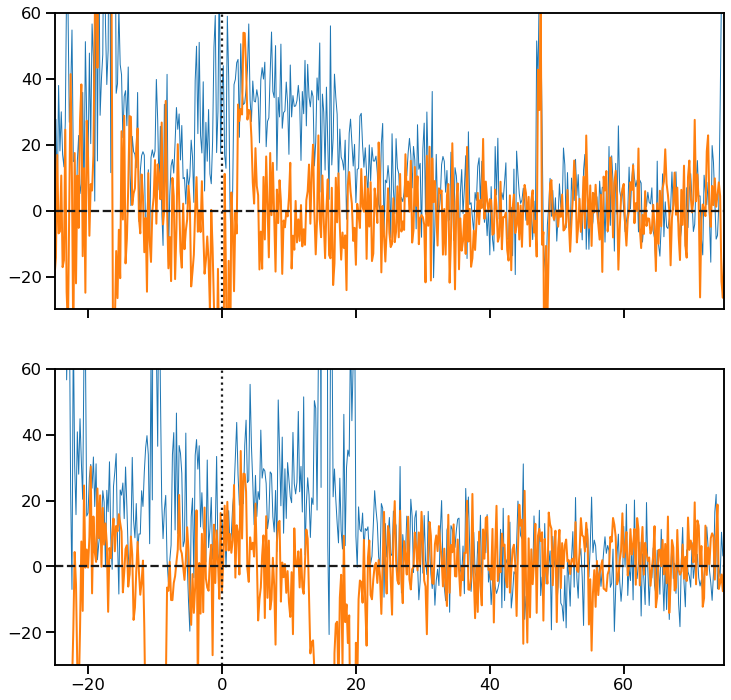

In [176]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(12, 12),
    sharex=True,
)
e = emlines["[Ar IV] 4740"]
axes[0].plot(e.A.position, e.A.data, linewidth=1.0, alpha=1.0)
axes[1].plot(e.B.position, e.B.data, linewidth=1.0, alpha=1.0)

e = emlines["He II 4686"]
axes[0].plot(e.A.position, e.A.data, linewidth=2.0, alpha=1.0)
axes[1].plot(e.B.position, e.B.data, linewidth=2.0, alpha=1.0)

axes[0].axhline(0.0, linestyle="dashed", color="k")
axes[0].axvline(0.0, linestyle="dotted", color="k")

axes[1].axhline(0.0, linestyle="dashed", color="k")
axes[1].axvline(0.0, linestyle="dotted", color="k")

for ax in axes:
    ax.set(
        xlim=[-25, 75],
        ylim=[-30, 60],
    )

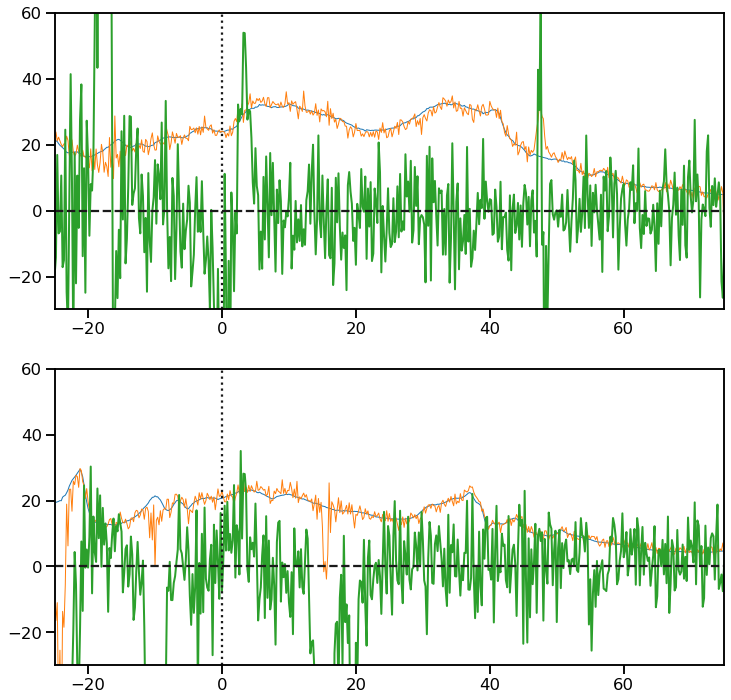

In [177]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
e = emlines["[O III] 5007"]
axes[0].plot(e.A.position, 1e-3 * e.A.data, linewidth=1.0, alpha=1.0)
axes[1].plot(e.B.position, 1e-3 * e.B.data, linewidth=1.0, alpha=1.0)

e = emlines["[O III] 4363"]
axes[0].plot(e.A.position, 0.075 * e.A.data, linewidth=1.0, alpha=1.0)
axes[1].plot(e.B.position, 0.075 * e.B.data, linewidth=1.0, alpha=1.0)

e = emlines["He II 4686"]
axes[0].plot(e.A.position, e.A.data, linewidth=2.0, alpha=1.0)
axes[1].plot(e.B.position, e.B.data, linewidth=2.0, alpha=1.0)

for ax in axes:
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.set(
        xlim=[-25, 75],
        ylim=[-30, 60],
    )

In [178]:
Amask = emlines["[O III] 5007"].ewA.data > 300.0
Bmask = emlines["[O III] 5007"].ewB.data > 300.0

for e in emlines.values():
    e.multiA = e.A.multibin(kmax=10, mask=Amask)
    e.multiB = e.B.multibin(kmax=10, mask=Bmask)

../lib/tetrabloks/rebin_utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  (profile[e] * mask[e] * weights[e] + profile[o] * mask[o] * weights[o])


oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile
oversample: nan(s) found in input profile
oversample: nan(s) found in output profile


In [179]:
e.multiB[512].data

array([nan, nan, nan, ..., nan, nan, nan])

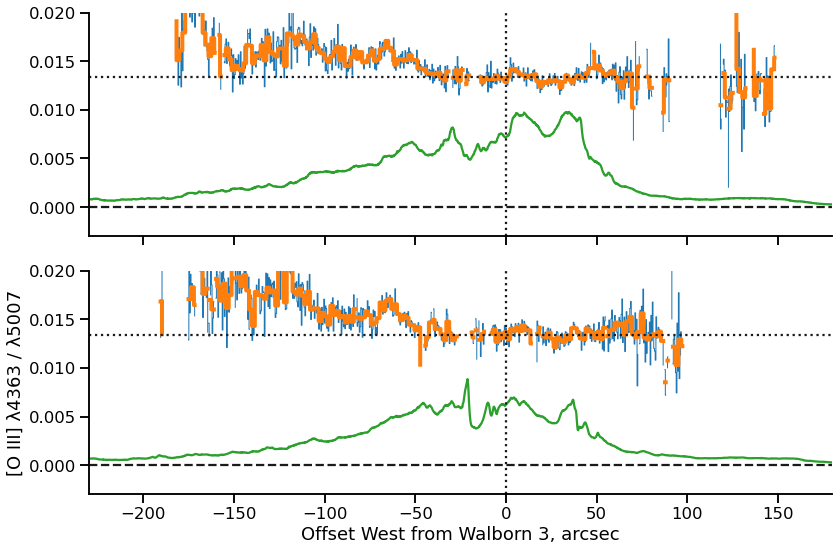

In [180]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
e1 = emlines["[O III] 4363"]
e2 = emlines["[O III] 5007"]
#min, xmax = -10, 50
xmin, xmax = -230, 180

n = 2
ratioA = e1.multiA[n].data / e2.multiA[n].data
ratioB = e1.multiB[n].data / e2.multiB[n].data
posA = e1.multiA[n].position
posB = e1.multiB[n].position
axes[0].plot(posA, ratioA, linewidth=1.0, alpha=1.0, drawstyle="steps-mid")
axes[1].plot(posB, ratioB, linewidth=1.0, alpha=1.0, drawstyle="steps-mid")

n = 8
ratioA = e1.multiA[n].data / e2.multiA[n].data
ratioB = e1.multiB[n].data / e2.multiB[n].data
posA = e1.multiA[n].position
posB = e1.multiB[n].position
axes[0].plot(posA, ratioA, linewidth=4.0, alpha=1.0, drawstyle="steps-mid")
axes[1].plot(posB, ratioB, linewidth=4.0, alpha=1.0, drawstyle="steps-mid")

axes[0].plot(e2.A.position, 3e-7*e2.A.data)
axes[1].plot(e2.B.position, 3e-7*e2.B.data)

#axes[0].plot(e1.cA.position, 5e-7*e1.cA.data)
#axes[1].plot(e1.cB.position, 5e-7*e1.cB.data)

m = (posA > -50) & (posA < xmax)
average_ratioA = np.nanmean(ratioA[m])
m = (posB > -50) & (posB < xmax)
average_ratioB = np.nanmean(ratioB[m])

average_ratio = np.mean([average_ratioA, average_ratioB])

for ax, ratio in zip(axes, [ratioA, ratioB]):
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axhline(
        average_ratio,
        linestyle="dotted", color="k",
    )
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.set(
        xlim=[xmin, xmax],
        ylim=[-0.003, 0.02],
    )
axes[-1].set(
    xlabel="Offset West from Walborn 3, arcsec",
    ylabel="[O III] λ4363 / λ5007",
)
sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-fors1-oiii-4363-5007-ratio.pdf");

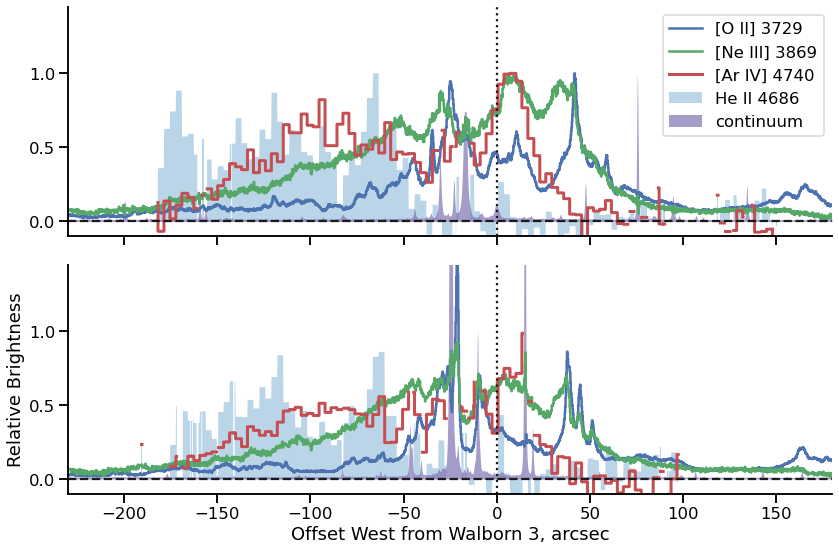

In [181]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(12, 8),
    sharex=True,
    sharey=True,
)
n = 16

e = emlines["He II 4686"]
fac = 1.0 / np.nanmax(e.multiA[n].data)
axes[0].fill_between(
    e.multiA[n].position, fac * e.multiA[n].data, 
    linewidth=2.0, alpha=0.3, 
    label=e.name,
)
axes[1].fill_between(
    e.multiB[n].position, fac * e.multiB[n].data, 
    linewidth=2.0, alpha=0.3, 
)

e = emlines["[O II] 3729"]
fac = 1.0 / np.nanmax(e.A.data)
axes[0].plot(
    e.A.position, fac * e.A.data, 
    linewidth=2.5, alpha=1.0, drawstyle="steps-mid", color="b",
    label=e.name,
)
axes[1].plot(
    e.B.position, fac * e.B.data, 
    linewidth=2.5, alpha=1.0, drawstyle="steps-mid", color="b",
)

e = emlines["[Ne III] 3869"]
fac = 1.0 / np.nanmax(e.A.data)
axes[0].plot(
    e.A.position, fac * e.A.data, 
    linewidth=2.5, alpha=1.0, drawstyle="steps-mid", color="g",
    label=e.name,
)
axes[1].plot(
    e.B.position, fac * e.B.data, 
    linewidth=2.5, alpha=1.0, drawstyle="steps-mid", color="g",
)

e = emlines["[Ar IV] 4740"]
fac = 1.0 / np.nanmax(e.multiA[n].data)
axes[0].plot(
    e.multiA[n].position, fac * e.multiA[n].data, 
    linewidth=3.0, alpha=1.0, drawstyle="steps-mid", color="r",
    label=e.name,
)
axes[1].plot(
    e.multiB[n].position, fac * e.multiB[n].data, 
    linewidth=3.0, alpha=1.0, drawstyle="steps-mid", color="r",
)


fac = 1.0 / np.nanmax(e.cA.data)
axes[0].fill_between(
    e.cA.position, fac * e.cA.data, 
    linewidth=0.0, alpha=0.7, color="m", 
    label="continuum",
)
axes[1].fill_between(
    e.cB.position, fac * e.cB.data, 
    linewidth=0.0, alpha=0.7, color="m", 
)



axes[0].axhline(0.0, linestyle="dashed", color="k")
axes[0].axvline(0.0, linestyle="dotted", color="k")

axes[1].axhline(0.0, linestyle="dashed", color="k")
axes[1].axvline(0.0, linestyle="dotted", color="k")

for ax in axes:
    ax.set(
        xlim=[xmin, xmax],
        ylim=[-0.1, 1.45],
    )
    
axes[0].legend()
axes[-1].set(
    xlabel="Offset West from Walborn 3, arcsec",
    ylabel="Relative Brightness",
)
sns.despine()
fig.tight_layout()
fig.savefig("../figs/ngc346-fors1-multiline-slit-profiles.pdf");

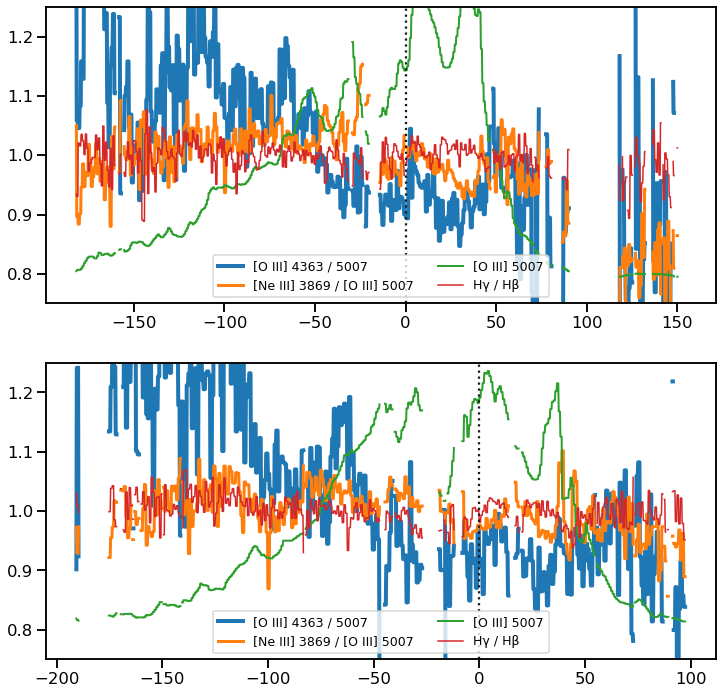

In [182]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
n = 4
sA = {e.name: e.multiA[n].data for e in emlines.values()}
e = emlines["[O III] 5007"]
posA = e.multiA[n].position
sB = {e.name: e.multiB[n].data for e in emlines.values()}
e = emlines["[O III] 5007"]
posB = e.multiB[n].position

for ax, pos, s in zip(axes, [posA, posB], [sA, sB]):
    ax.plot(
        pos,
        s["[O III] 4363"]
        / s["[O III] 5007"]
        / np.nanmedian(s["[O III] 4363"] / s["[O III] 5007"]),
        linewidth=4.0,
        alpha=1.0,
        label="[O III] 4363 / 5007",
    )
    ax.plot(
        pos,
        s["[Ne III] 3869"]
        / s["[O III] 5007"]
        / np.nanmedian(s["[Ne III] 3869"] / s["[O III] 5007"]),
        linewidth=3.0,
        alpha=1.0,
        label="[Ne III] 3869 / [O III] 5007",
    )
    ax.plot(
        pos,
        0.75 + 0.2 * s["[O III] 5007"] / np.nanmedian(s["[O III] 5007"]),
        #    0.1* s4341 / np.median(s4341),
        linewidth=2.0,
        alpha=1.0,
        label="[O III] 5007",
    )
    ax.plot(
        pos,
        s["H I 4340"] / s["H I 4861"] / np.nanmedian(s["H I 4340"] / s["H I 4861"]),
        linewidth=1.5,
        alpha=1.0,
        label="Hγ / Hβ",
    )
    # ax.plot(positions, 0.0003 * s4686, linewidth=2.0, alpha=1.0)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")

    ax.legend(fontsize="x-small", ncol=2)
    ax.set(
        # xlim=[-10, 50],
        #xlim=[-230, 200],
        ylim=[0.75, 1.25],
    )

In [160]:
posA[np.isfinite(posA)]

array([ 154.4,  150.2,  150. , ..., -181.4, -181.6, -181.8])

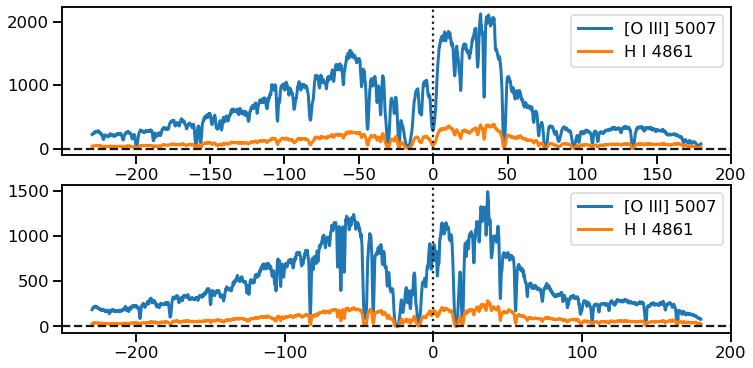

In [134]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax, ew in zip(axes, ["ewA", "ewB"]):
    for line in "[O III] 5007", "H I 4861":
        p = getattr(emlines[line], ew)        
        ax.plot(p.position, p.data, linewidth=3.0, alpha=1.0, label=line)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        # xlim=[-10, 50],
        # ylim=[-0.003, 0.02],
    )

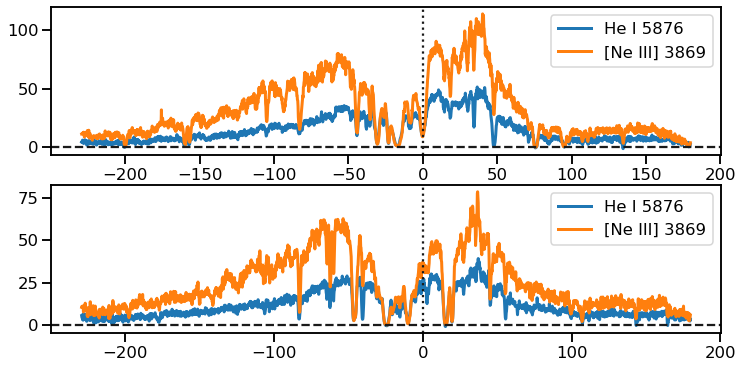

In [135]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax, ew in zip(axes, ["ewA", "ewB"]):
    for line in "He I 5876", "[Ne III] 3869":
        p = getattr(emlines[line], ew)        
        ax.plot(p.position, p.data, linewidth=3.0, alpha=1.0, label=line)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        # xlim=[-10, 50],
        # ylim=[-0.003, 0.02],
    )

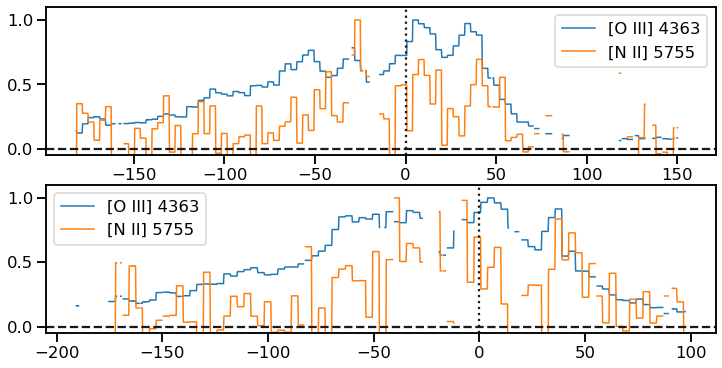

In [132]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
n = 16
for ax, multi in zip(axes, ["multiA", "multiB"]):
    for line in "[O III] 4363", "[N II] 5755":
        p = getattr(emlines[line], multi)[n]
        ax.plot(p.position, p.data / np.nanmax(p.data), linewidth=1.5, alpha=1.0, label=line)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
        # xlim=[-10, 50],
        ylim=[-0.05, 1.1],
    )

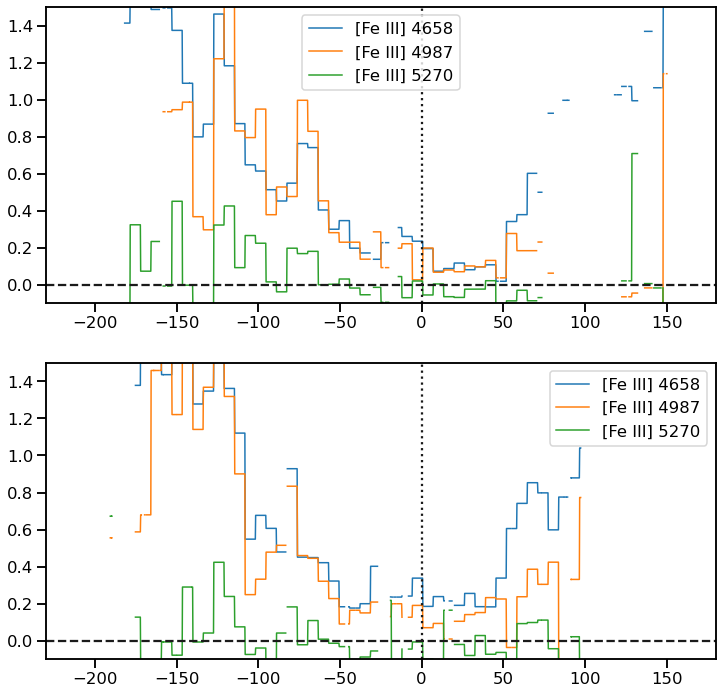

In [191]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
n = 32
for ax, multi in zip(axes, ["multiA", "multiB"]):
    for line in "[Fe III] 4658", "[Fe III] 4987", "[Fe III] 5270":
        p = getattr(emlines[line], multi)[n]
        scale = 100 / getattr(emlines["H I 4861"], multi)[n].data
        if "4987" in line:
            correct = getattr(emlines["Wing 4975"], multi)[n].data
        else:
            correct = 0.0
        ax.plot(p.position, scale * (p.data - correct), linewidth=1.5, alpha=1.0, label=line)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.legend()
    ax.set(
#        xlim=[-100, 50],
        xlim=[xmin, xmax],
        ylim=[-0.1, 1.5],
    )